# DMRG with Spin-Orbit-Coupling

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/dmrg-soc.ipynb)

In [1]:
!pip install block2==0.5.3rc5 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/
!pip install pyscf==2.3.0 -qq --progress-bar off
!pip install git+https://github.com/pyscf/dmrgscf -qq --progress-bar off
!wget -q https://raw.githubusercontent.com/pyscf/dmrgscf/master/pyscf/dmrgscf/settings.py.example
!mv settings.py.example $(pip show pyscf-dmrgscf | grep 'Location' | tr ' ' '\n' | tail -n 1)/pyscf/dmrgscf/settings.py

  Preparing metadata (setup.py) ... done


## Introduction

In this tutorial we explain how to perform quantum chemistry DMRG calculation with the spin-orbit-coupling (SOC) term in the Hamiltonian. As a testing system, we consider the low energy spectrum of $\mathrm{[DyCl_6]^{3-}}$, which has been studied in

* H. Zhai, and G. K.-L. Chan. A comparison between the one- and two-step spin-orbit coupling approaches based on the ab initio Density Matrix Renormalization Group. *J. Chem. Phys.* **157**, 164108 (2022). doi: [10.1063/5.0107805](https://doi.org/10.1063/5.0107805)

The experimental data can be found in the supporting information Table S10 of:

* D. Aravena, M. Atanasov, and F. Neese. Periodic trends in lanthanide compounds through the eyes of multireference ab initio theory. *Inorg. Chem.* **55**, 4457-4469 (2016). doi: [10.1021/acs.inorgchem.6b00244](https://doi.org/10.1021/acs.inorgchem.6b00244)


In [2]:
from pyscf import scf, mcscf, gto, dmrgscf, lib
from pyblock2._pyscf import scf as b2scf
from pyblock2._pyscf import mcscf as b2mcscf
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyblock2._pyscf.ao2mo import soc_integrals as itgsoc
import numpy as np
import os

dmrgscf.settings.BLOCKEXE = os.popen("which block2main").read().strip()
dmrgscf.settings.MPIPREFIX = ''

/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


## Mean-Field Calculations

We first do mean-field calculations without SOC to get a set of starting orbitals.

In [3]:
b = 2.72
coords = [["Dy", [0, 0, 0]]] + [["Cl", [0] * p + [i] + [0] * (2 - p)] for p in [0, 1, 2] for i in [-b, b]]
mol = gto.M(atom=coords, basis={"Dy": "ano@9s8p5d4f", "Cl": "ano@4s3p"}, verbose=3, spin=5, charge=-3)
print('basis = dz nelec = %d nao = %d' % (mol.nelectron, mol.nao))

mf = scf.UKS(mol).x2c()
mf = b2scf.smearing_(mf, sigma=0.2, method="fermi", fit_spin=True)
mf.xc = "bp86"
mf.verbose = 4

dm0 = b2scf.get_metal_init_guess(mol, orb="4f", atom_idxs=[0], coupling="+", atomic_spin=5)
mf.kernel(dm0=dm0)
dmao = np.einsum('yij->ij', mf.make_rdm1(), optimize=True)

lo_coeff, lo_occ, lo_energy = b2mcscf.get_uno(mf)
selected = b2mcscf.select_active_space(mol, lo_coeff, lo_occ, ao_labels=["Dy-4f"], atom_order=[0])
lo_coeff, lo_occ, lo_energy, nactorb, nactelec = b2mcscf.sort_orbitals(mol, lo_coeff,
    lo_occ, lo_energy, cas_list=selected, do_loc=True, split_low=0.1, split_high=1.9)

b2scf.mulliken_pop_dmao(mol, mf.make_rdm1())

mf = scf.RHF(mol).x2c()
mf.mo_coeff = lo_coeff
mf.mo_occ = np.array([int(np.round(x) + 0.1) for x in lo_occ])
assert sum(mf.mo_occ) == mol.nelectron
mf.mo_energy = lo_energy

basis = dz nelec = 171 nao = 164


******** <class 'pyscf.x2c.sfx2c1e.sfx2c1e.<locals>.SFX2C1E_SCF'> ********
method = SFX2C1E_SCF-UKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /content/tmpuiy5aay9
max_memory 4000 MB (current use 163 MB)
number electrons alpha = 88  beta = 83
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 7, 1–5 (2018)
XC functionals = bp86
    A. D. Becke.,  Phys. Rev. A 38, 3098 (1988)
    J. P. Perdew.,  Phys. Rev. B 33, 8822 (1986)
small_rho_cutoff = 1e-07
Set gradient conv threshold to 3.16228e-05


Overwritten attributes  get_grad get_occ energy_tot  of <class 'pyscf.x2c.sfx2c1e.sfx2c1e.<locals>.SFX2C1E_SCF'>


init E= -14787.0872479682

WARN: alpha nocc = 88  HOMO 0.0611863318980825 >= LUMO 0.0613044136748146


WARN: beta  nocc = 83  HOMO 0.0739533459338481 >= LUMO 0.0739533459486078

    sigma = 0.2  Optimized mu = [-0.01549092 -0.10180943]  entropy = 58.5500123445
    Total E(T) = -14913.1615642987  Free energy = -14924.8715667676  E0 = -14919.0165655332
cycle= 1 E= -14913.1615642987  delta_E= -126  |g|= 12.9  |ddm|=  6.1

WARN: alpha nocc = 88  HOMO -0.121609089741254 >= LUMO -0.121609089734184


WARN: beta  nocc = 83  HOMO -0.23372079326522 >= LUMO -0.233720793220507


WARN: system HOMO -0.109118498567311 >= system LUMO -0.233720793220507

    sigma = 0.2  Optimized mu = [-0.21224349 -0.32945095]  entropy = 47.6143433007
    Total E(T) = -14720.9861471891  Free energy = -14730.5090158493  E0 = -14725.7475815192
cycle= 2 E= -14720.9861471891  delta_E=  192  |g|= 52.6  |ddm|= 7.48

WARN: alpha nocc = 88  HOMO -0.0245777519477351 >= LUMO -0.0245777519129139


WARN: beta  nocc = 83  HOMO -0.

## CASSCF Calculations

Next, we do state-averaged CASSCF for all sextet (pure total spin) states (without SOC). Unlike the procedure used in the first reference listed above, here we only do state-average for sextet, so that the result can be compariable with the "CASSCF-HS" results in the 2016 reference literature.

In [4]:
lib.param.TMPDIR = os.path.abspath("./tmp")

mc = mcscf.CASSCF(mf, nactorb, nactelec)
mc.fcisolver = dmrgscf.DMRGCI(mol, maxM=1500, tol=1E-10)
mc.fcisolver.spin = 5
mc.fcisolver.nroots = 21
mc.fcisolver.runtimeDir = os.path.abspath(lib.param.TMPDIR)
mc.fcisolver.scratchDirectory = os.path.abspath(lib.param.TMPDIR)
mc.fcisolver.threads = 4
mc.fcisolver.memory = int(mol.max_memory / 1000) # mem in GB
mc.fcisolver.block_extra_keyword = ["real_density_matrix",
    "davidson_soft_max_iter 1600", "noreorder", "cutoff 1E-24"]
mc = mcscf.state_average_(mc, [1.0 / 21] * 21)
mc.verbose = 4
mc.kernel()
mf.mo_coeff = mc.mo_coeff

ncore = mc.ncore
ncas = mc.ncas
print('ncore = ', ncore, ' ncas = ', ncas)


******** <class 'pyscf.mcscf.addons._state_average_mcscf_solver.<locals>.StateAverageMCSCF'> ********
CAS (7e+2e, 7o), ncore = 81, nvir = 76
max_cycle_macro = 50
max_cycle_micro = 4
conv_tol = 1e-07
conv_tol_grad = None
orbital rotation max_stepsize = 0.02
orbital rotation threshold for CI restart = 0.01
augmented hessian ah_max_cycle = 30
augmented hessian ah_conv_tol = 1e-12
augmented hessian ah_linear dependence = 1e-14
augmented hessian ah_level shift = 1e-08
augmented hessian ah_start_tol = 2.5
augmented hessian ah_start_cycle = 3
augmented hessian ah_grad_trust_region = 3
kf_trust_region = 3
kf_interval = 4
ci_response_space = 4
ci_grad_trust_region = 3
with_dep4 0
natorb = False
canonicalization = True
sorting_mo_energy = False
ao2mo_level = 2
chkfile = /content/tmpryjxvk8l
max_memory 4000 MB (current use 911 MB)
internal_rotation = False

******** Block flags ********
executable             = /usr/local/bin/block2main
BLOCKEXE_COMPRESS_NEVPT= /path/to/serially/compiled/Block/b

## 1-Step SOC-DMRG

Now we do 1-step CASCI-DMRG within the (9e, 7o) active space with the SOC effect considered using SOMF approximation.

In [5]:
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itgsoc.get_rhf_somf_integrals(
    mf, ncore, ncas, pg_symm=False, dmao=dmao, amfi=True, x2c1e=False, x2c2e=False
)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SGFCPX, stack_mem=4 << 30, n_threads=4)
idx = driver.orbital_reordering(np.abs(h1e), np.abs(g2e))
print('reordering = ', idx)
h1e = h1e[idx][:, idx]
g2e = g2e[idx][:, idx][:, :, idx][:, :, :, idx]

driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=0, orb_sym=orb_sym)
h1e[np.abs(h1e) < 1e-10] = 0
g2e[np.abs(g2e) < 1e-10] = 0

mpo = driver.get_qc_mpo(h1e, g2e, ecore=ecore)
ket = driver.get_random_mps(tag="KET", bond_dim=250, nroots=16)
bond_dims = [500] * 5 + [1000] * 5 + [1500] * 5
noises = [1e-4] * 5 + [1e-5] * 5 + [1e-6] * 5 + [0]
thrds = [1e-5] * 5 + [1e-5] * 5 + [1e-7] * 5 + [1E-8]
energies = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1, dav_max_iter=400, cutoff=1E-24)

au2cm = 219474.63111558527
au2ev = 27.21139
e0 = energies[0]

ener_cm = []

for ix, ex in enumerate(energies):
    ener_cm.append((ex - e0) * au2cm)
    print("%5d %20.10f Ha %15.6f eV %10.4f cm-1" % (ix, ex, (ex - e0) * au2ev, (ex - e0) * au2cm))

reordering =  [ 5 13 11  1  9  3  7  6  2  8  0 10 12  4]
integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =       4139

Build MPO | Nsites =    14 | Nterms =       4139 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /    14 .. Mmpo =     9 DW = 0.00e+00 NNZ =        9 SPT = 0.0000 Tmvc = 0.001 T = 0.007
 Site =     1 /    14 .. Mmpo =    26 DW = 0.00e+00 NNZ =       51 SPT = 0.7821 Tmvc = 0.001 T = 0.006
 Site =     2 /    14 .. Mmpo =    37 DW = 0.00e+00 NNZ =      103 SPT = 0.8929 Tmvc = 0.001 T = 0.008
 Site =     3 /    14 .. Mmpo =    44 DW = 0.00e+00 NNZ =      243 SPT = 0.8507 Tmvc = 0.001 T = 0.007
 Site =     4 /    14 .. Mmpo =    47 DW = 0.00e+00 NNZ =      173 SPT = 0.9163 Tmvc = 0.001 T = 0.007
 Site =     5 /    14 .. Mmpo =    54 DW = 0.00e+00 NNZ =      151 SPT = 0.9405 Tmvc = 0.001 T = 0.007
 Site =     6 /    14 .. Mmpo =    65 DW = 0.00e+00 NNZ =      103 SPT = 0.9707 Tmvc = 0.001 T = 0.016
 Site =     7 /    14 .. Mmpo =    54 DW = 0

## Plot the results

In the following we plot the results. The experiment and ref data are from Table S10 of the second reference listed above. The difference between the experiment data and the CASSCF data is mainly from the missing dynamic correlation. The difference between ref and DMRG-SOC is mainly from the basis set and different method used.

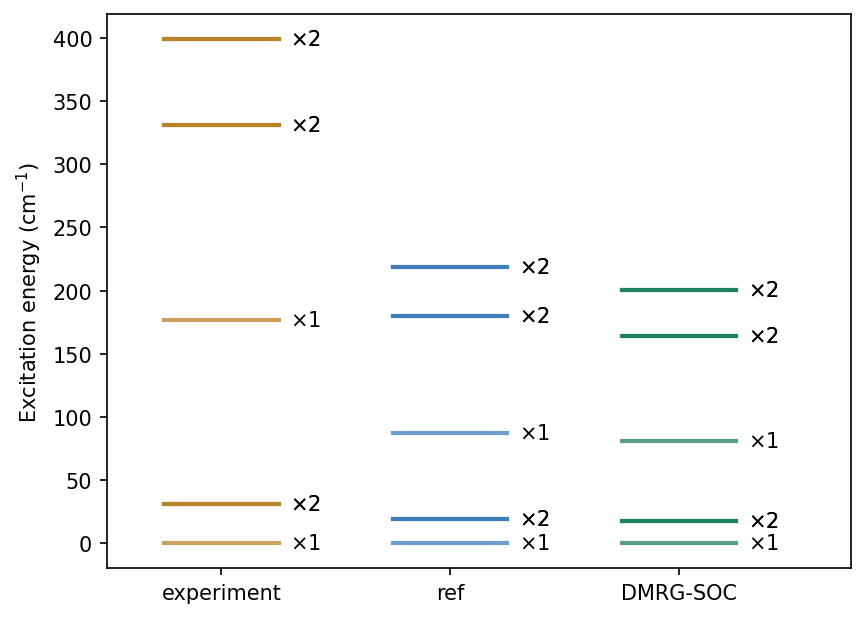

In [6]:
import matplotlib.pyplot as plt
import numpy as np

ener_exp = [0, 31, 31, 177, 331, 331, 399, 399]
ener_ref = [0, 19.2, 19.2, 87.2, 179.9, 179.9, 218.9, 218.9]
ener = [round((i + j ) / 2, 1) for i, j in zip(ener_cm[::2], ener_cm[1::2])]

for i in range(len(ener_exp)):
    plt.text(2.1, ener_exp[i], "$\\times%d$" % ener_exp.count(ener_exp[i]), verticalalignment='center', fontsize=10)
    plt.plot([1, 2], [ener_exp[i]] * 2, '-', linewidth=2, color="#B1740F", alpha=0.67)
    plt.text(4.1, ener_ref[i], "$\\times%d$" % ener_ref.count(ener_ref[i]), verticalalignment='center', fontsize=10)
    plt.plot([3, 4], [ener_ref[i]] * 2, '-', linewidth=2, color="#296EB4", alpha=0.67)
    plt.text(6.1, ener[i], "$\\times%d$" % ener.count(ener[i]), verticalalignment='center', fontsize=10)
    plt.plot([5, 6], [ener[i]] * 2, '-', linewidth=2, color="#04724D", alpha=0.67)
plt.xlim((0.5, 7))
plt.xticks([1.5, 3.5, 5.5], ["experiment", "ref", "DMRG-SOC"])
plt.ylabel("Excitation energy ($\\mathrm{cm^{-1}}$)")
plt.gcf().set_dpi(150)
plt.show()